# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 5: Predicting College Admissions

**Harvard University**<br/>
**Fall 2021**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai

<hr style="height:2.4pt">

In [1]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

### Import Libraries

In [2]:
# RUN THIS CELL
import itertools
import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

%matplotlib inline

<a id="instructions"></a>

<hr style="height:2pt">

### INSTRUCTIONS


- To submit your assignment follow the instructions given in Canvas.

- Please **restart the kernel and run the entire notebook again before you submit.**

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code continues to work, restart the kernel and rerun your notebook periodically while working through this assignment. 

- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. **Please use only the libraries provided in those imports.**

- Please use `.head(...)` when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate and report $R^2$", do not just output the value from a cell. Write a `print(...)` function that clearly labels the output, includes a reference to the calculated value, and rounds it to a reasonable number of digits. **Do not hard code values in your printed output**. For example, this is an appropriate print statement:
```python
print(f'The R^2 is {R:.4f}')
```
- **Your plots MUST be clearly labeled and easy to read,** including clear labels for the $x$ and $y$ axes, a descriptive title ("MSE plot" is NOT a descriptive title; "95% confidence interval of coefficients for degree-5 polynomial model" on the other hand is descriptive), a legend when appropriate, and clearly formatted text and graphics.

- **Your code may also be evaluated for efficiency and clarity.** As a result, correct output is not always sufficient for full credit.

<hr style="height:2pt">

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Data exploration using train and basic models [16 pts]**](#part1)
  - [Solutions](#part1solutions)


- [**Question 2: Interpretable modeling [18 pts]**](#part2)
  - [Solutions](#part2solutions)


- [**Question 3: Harvard and Yale? [30 pts]**](#part3)
  - [Solutions](#part3solutions)


- [**Question 4: Building predictive models for admitted [24 pts]**](#part4)
  - [Solutions](#part4solutions)


- [**Question 5: Evaluating results [12 pts]**](#part5)
  - [Solutions](#part5solutions)

<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)

### Predicting admissions into elite universities

In this problem set we will model the chances of high school students being accepted into two different elite undergraduate colleges (one is elite at least :) ): Harvard and Yale.  The data are provided in the file `data/college_admissions.csv` and were scraped from [collegedata.com](https://www.collegedata.com/) (where applicants volunteer to share their information).  Each observation corresponds to an applicant to one of the two different colleges (note: the same applicant may show up in two rows: once for each college).  The main response is the `"admitted"` variable (1 = admitted, 0 = denied), and there are are several predictors to consider:

- **id**: a unique identifier for the applicant 
- **test**: a standardized measurement of the applicant's highest ACT or SAT combined score (2400 is the maximum)
- **ap**: the number of AP tests taken
- **avg_ap**: the average score on the AP tests taken (0 if no tests were taken)
- **sat_subjects**: the number of SAT subject tests taken
- **gpa**: the unweighted GPA of the applicant (max of 4.0)
- **female**:  a binary indicator for gender: 1 = female, 0 = otherwise
- **minority**: a binary indicator for under-represented minority: 1 = minority, 0 = otherwise 
- **international**: a binary indicator for international status: 1 = international, 0 = United States
- **sports**: a binary indicator for High School All-American: 1 = all-American athlete, 0 = otherwise
- **school**: a categorical variable for school applied to: "Harvard" or "Yale"
- **early_app**: a binary indicator for application type: 1 = early action, 0 = regular
- **alumni**:  a binary indicator for parents' alumni status of school: 1 = a parent is an alumnus, 0 = otherwise
- **program**: the program applied to by the student with many choices (we will not use this as a predictor)
- **add_info**: additional (optional) info provided by applicant (we will not use this as a predictor)

**The main set of 12 predictors is:**

```python
[
    "test", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "school", "early_app", "alumni",
]
```

Please note, you may need to modify this list when fitting different models, and you will be replacing the `"school"` variable with a binary `"harvard"` variable early in the questions below.

Please use this dataset to answer the following questions below.

**IMPORTANT NOTES:**

- Unless stated otherwise, all logistic regression models should be unregularized (use `penalty="none"`) and include the intercept (which is the default in `sklearn`).


- When printing your output (e.g. coefficients, accuracy scores, etc.), DO NOT just print numbers without context. Please be certain provide clarifying labels for all printed numbers and limit the number of digits showing after decimals to a reasonable length (e.g. 4 decimal points for coefficients and accuracy scores).


- Also be sure to practice good data science principles: always use train to do analysis and never touch the test set until the very end.

---

<a id="part1"></a>

## <div class='exercise'>Question 1: Data exploration using train and basic models [16 pts]</div>

[Return to contents](#contents)

The first step is to split the observations into an approximate 80-20 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). It also prints the dataset's shape before splitting and after splitting. 

**IMPORTANT:** While an argument could be made to scale our predictors here, please **DO NOT** do so **UNTIL** it is requested of you in **[Question 4.1](#part4)**.

**1.1** What proportion of observations were admitted overall?  What would be the train and test classification accuracies for a baseline "naive" model where we classified ALL applicants as either admitted or not admitted using just this overall proportion to make our decision (i.e. we apply the same outcome to all applicants based on this proportion)?

**1.2** Create a binary ("dummy") variable named `"harvard"` that takes on the value 1 if `school == "Harvard"` and 0 otherwise. Now, explore the marginal association of each of our 12 predictors with whether or not an applicant is admitted into the college to which they applied (`admitted`). Create a separate **visual** for each of our predictors to investigate their relationship with college admissions. **Suggestion:** Place these 12 visuals in a *matrix* of subplots with 3 columns and 4 rows.

**NOTE:** We will be using our dummified `harvard` predictor instead of `school` throughout the remainder of this problem set.

**1.3** Based on the visuals above, which predictor seems to have the most potential for predicting `admitted`? Why do you think this it the best potential single predictor?


**1.4** Fit a logistic regression to predict `admitted` from `harvard` (call it `logit1_4`).  Interpret the coefficient estimates: which college is estimated to be easier to get into?  What are the estimated probabilities of getting into each school?


**1.5** Create a contingency table between `admitted` and `harvard`.  Use this table to calculate and confirm the coefficient estimates in the `logit1_4` model (both the intercept and slope).


**1.6** Compare the estimated probabilities of being admitted into the schools to the overall acceptance rate (as seen [here](https://www.ivycoach.com/2023-ivy-league-admissions-statistics/)).  Why may what you've observed in this comparison be the case?


In [3]:
#############################
## DO NOT MODIFY THIS CODE ##
#############################

college = pd.read_csv("data/college_admissions.csv")
np.random.seed(121)

college_train, college_test = train_test_split(
    college,
    test_size=0.2,
    random_state=121,
    shuffle=True,
    stratify=college["school"],
)

print(college.shape)
print(college_train.shape, college_test.shape)

(1871, 16)
(1496, 16) (375, 16)


<a id="part1solutions"></a>

## Question 1: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**1.1** What proportion of observations were admitted overall?  What would be the train and test classification accuracies for a baseline "naive" model where we classified ALL applicants as either admitted or not admitted using just this overall proportion to make our decision (i.e. we apply the same outcome to all applicants based on this proportion)?
    
</div>

In [4]:
# your code here
prop1_1 = college["admitted"].mean()
print(f"The proportion of observations admitted is {prop1_1:.4f}.")
acc_tr_1_1 = sum(college_train['admitted'] == 0)/college_train['admitted'].shape[0]
acc_ts_1_1 = sum(college_test['admitted'] == 0)/college_test['admitted'].shape[0]
print(f"If we use proportion {prop1_1:.4f} to make decision on train and test data. The accuracies on train and test data are {acc_tr_1_1:.4f} and {acc_ts_1_1:.4f} respectively.")

The proportion of observations admitted is 0.2699.
If we use proportion 0.2699 to make decision on train and test data. The accuracies on train and test data are 0.7373 and 0.7013 respectively.


<div class='exercise-r'>

**1.2** Create a binary ("dummy") variable named `"harvard"` that takes on the value 1 if `school == "Harvard"` and 0 otherwise. Now, explore the marginal association of each of our 12 predictors with whether or not an applicant is admitted into the college to which they applied (`admitted`). Create a separate **visual** for each of our predictors to investigate their relationship with college admissions. **Suggestion:** Place these 12 visuals in a *matrix* of subplots with 3 columns and 4 rows.

**NOTE:** We will be using our dummified `harvard` predictor instead of `school` throughout the remainder of this problem set.
    
</div>

<ipython-input-5-f3165d99081a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  college_train['harvard'] = (college_train["school"] == "Harvard").astype(int)
<ipython-input-5-f3165d99081a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  college_test['harvard'] = (college_test["school"] == "Harvard").astype(int)


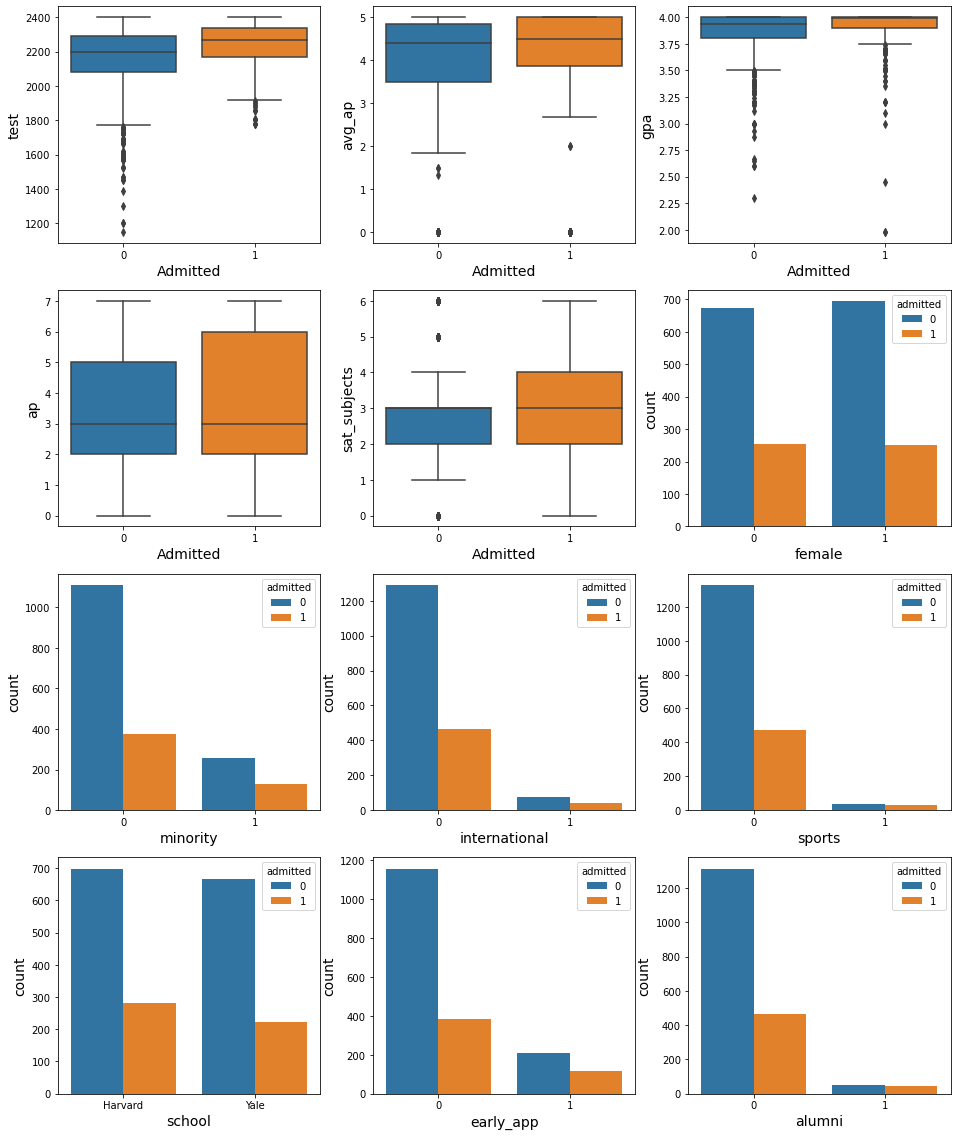

In [5]:
# your code here
college['harvard'] = (college["school"] == "Harvard").astype(int)
college_train['harvard'] = (college_train["school"] == "Harvard").astype(int)
college_test['harvard'] = (college_test["school"] == "Harvard").astype(int)

cols = ["test", "avg_ap", "gpa", 
       "ap", "sat_subjects","female", "minority", "international",
        "sports", "school", "early_app", "alumni"]

college12=college[["admitted","test", "ap", "avg_ap", "sat_subjects", "gpa",
                   "female", "minority", "international","sports", "school", "early_app", "alumni"]]

fig, axes = plt.subplots(4,3,figsize=(16,20))
axes = axes.ravel()
for i, c in enumerate(cols):
    if c in ["test", "avg_ap", "gpa","ap", "sat_subjects"]:
        sns.boxplot(data=college12, x='admitted',y=c, ax=axes[i])
        axes[i].set_xlabel("Admitted", size=14)
        axes[i].set_ylabel(c,size=14)
    else:
        tmp = (college12.groupby('admitted')[c].value_counts().to_frame().rename(columns={c: 'count'})).reset_index()
        sns.barplot(data=tmp, x=c, y='count', hue='admitted', ax=axes[i])
        axes[i].set_xlabel(c, size=14)
        axes[i].set_ylabel("count",size=14)



<div class='exercise-r'>

**1.3** Based on the visuals above, which predictor seems to have the most potential for predicting `admitted`? Why do you think this it the best potential single predictor?
    
</div>

**Sports, Alumni, GPA seem to have the most potential for predicting admitted. Those who were admitted have higher mean GPA and lower standard deviation than those who were not admitted. A large portion of alumni were admitted compared to those who are not alumni. A large portion of all-American athlete were admitted compared to those who are not all-American athlete.**

<div class='exercise-r'>
    
**1.4** Fit a logistic regression to predict `admitted` from `harvard` (call it `logit1_4`).  Interpret the coefficient estimates: which college is estimated to be easier to get into?  What are the estimated probabilities of getting into each school?
    
</div>

In [6]:
# your code here
X_train = college_train[['harvard']]
y_train = college_train['admitted']

logit1_4 = LogisticRegression(penalty="none")
logit1_4.fit(X_train,y_train)

print(f"Logistic Regression Estimated Beta (B0): {logit1_4.intercept_[0]:.4f} and Odds: {np.exp(logit1_4.intercept_)[0]:.4f}.")
print(f"Logistic Regression Estimated Beta (B1): {logit1_4.coef_[0][0]:.4f} and Odds Ratio (OR): {np.exp(logit1_4.coef_)[0][0]:.4f}.")

p_harvard = np.exp(logit1_4.coef_+logit1_4.intercept_)/(1+ np.exp(logit1_4.coef_+logit1_4.intercept_))
p_yale = np.exp(logit1_4.intercept_)/(1+ np.exp(logit1_4.intercept_))
print(f"The probability of getting to Harvard and Yale is {p_harvard[0][0]:.4f} and {p_yale[0]:.4f}, respectively.")

Logistic Regression Estimated Beta (B0): -1.1137 and Odds: 0.3284.
Logistic Regression Estimated Beta (B1): 0.1532 and Odds Ratio (OR): 1.1655.
The probability of getting to Harvard and Yale is 0.2768 and 0.2472, respectively.


**INTERPRETATION:**

**The Odds of getting into Harvard is 1.1655 times the odds of getting into Yale. Harvard is estimated to be easier to get into. The probabilities of getting into Harvard is 0.2768 while the probability of getting into Yale is 0.2472.**

<div class='exercise-r'>

**1.5** Create a contingency table between `admitted` and `harvard`.  Use this table to calculate and confirm the coefficient estimates in the `logit1_4` model (both the intercept and slope).

</div>

In [7]:
# your code here
crosstable = pd.crosstab(college_train['admitted'], college_train['harvard'], margins = False)
print(crosstable)
p_h = (crosstable[1][1]) / (crosstable[1][0] + crosstable[1][1])
p_y = (crosstable[0][1]) / (crosstable[0][0] + crosstable[0][1])

print(f"The probability of getting into Harvard and Yale is {p_h:.4f} and {p_y:.4f}, respectively. \nThe values match the coefficient estimates in the logit1_4 model (both the intercept and slope).")

harvard     0    1
admitted          
0         536  567
1         176  217
The probability of getting into Harvard and Yale is 0.2768 and 0.2472, respectively. 
The values match the coefficient estimates in the logit1_4 model (both the intercept and slope).


<div class='exercise-r'>

**1.6** Compare the estimated probabilities of being admitted into the schools to the overall acceptance rate (as seen [here](https://www.ivycoach.com/2023-ivy-league-admissions-statistics/)).  Why may what you've observed in this comparison be the case?
    
</div>

**The overall acceptance rate of Harvard and Yale are 0.045 and 0.059, respectively. The estimated probabilities of being admitted into these schools are 0.2768 and 0.2472, respectively. The difference maybe due to the fact the data were scraped from a website where applicants volunteer to share their information, so successful volunteers are more likely to share there data.**

---

<a id="part2"></a>

## <div class='exercise'>Question 2: Interpretable modeling [18 pts]</div>

[Return to contents](#contents)

**2.1** Fit a logistic regression model to predict `admitted` from `test` alone (call it `logit2_1`).  Print out the coefficient estimates (remember to always print both intercept and slope coefficients) along with the classification accuracies for this model (on both train and test data). 

**2.2** What is the estimated probability of an applicant being admitted with an *average* `test` score of 2250?  What about if they had a perfect test score of 2400?  What test score would be needed to have a 50-50 chance (i.e. 0.5 probability) of being admitted?

**2.3**  Fit a logistic regression model to predict `admitted` from `test` and `avg_ap` (call it `logit2_3`).  Print out the coefficient estimates along with the classification accuracies for this model (on both train and test data). 

**2.4** Interpret the coefficient estimates for both predictors in `logit2_3` and compare the coefficient estimate for `test` to the one from `logit2_1`.  Why has this estimate changed?

**HINT:** You may want to inspect the relationship between `test` and `avg_ap` to help get a better sense for what might be happening here.

**2.5** Interpret and compare the classification accuracies for the two models, `logit2_1` and `logit2_3`.  Explain why these accuracies are the same or different, and what about the data makes these accuracies so similar or different.


<a id="part2solutions"></a>

## Question 2: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**2.1** Fit a logistic regression model to predict `admitted` from `test` alone (call it `logit2_1`).  Print out the coefficient estimates (remember to always print both intercept and slope coefficients) along with the classification accuracies for this model (on both train and test data).
    
</div>

In [8]:
# your code here
X_train = college_train[['test']]
y_train = college_train['admitted']

X_test = college_test[['test']]
y_test = college_test['admitted']

logit2_1 = LogisticRegression(penalty="none")
logit2_1.fit(X_train,y_train)

print(f"Logistic Regression Estimated Beta (B0): {logit2_1.intercept_[0]:.4f} and Odds: {np.exp(logit2_1.intercept_)[0]:.4f}.")
print(f"Logistic Regression Estimated Beta (B1): {logit2_1.coef_[0][0]:.4f} and Odds Ratio (OR): {np.exp(logit2_1.coef_)[0][0]:.4f}.")

y_train_pred = logit2_1.predict(X_train)
y_test_pred = logit2_1.predict(X_test)
acc_tr_2_1 = accuracy_score(y_train,y_train_pred)
acc_ts_2_1 = accuracy_score(y_test,y_test_pred)

print(f"Classification accuracies on training and test data are {acc_tr_2_1:.4f} and {acc_ts_2_1:.4f}, respectively.");

Logistic Regression Estimated Beta (B0): -9.4136 and Odds: 0.0001.
Logistic Regression Estimated Beta (B1): 0.0038 and Odds Ratio (OR): 1.0038.
Classification accuracies on training and test data are 0.7373 and 0.7013, respectively.


<div class='exercise-r'>

**2.2** What is the estimated probability of an applicant being admitted with an *average* `test` score of 2250?  What about if they had a perfect test score of 2400?  What test score would be needed to have a 50-50 chance (i.e. 0.5 probability) of being admitted?
    
</div>

In [9]:
# your code here
print(f"The probability of an applicant being admitted with an average test score of 2250 is {logit2_1.predict_proba([[2250]])[0][1]:.4f}.")
print(f"The probability of an applicant being admitted with an average test score of 2400 is {logit2_1.predict_proba([[2400]])[0][1]:.4f}.")
print(f"The probability of an applicant being admitted with an average test score of 2482 is {logit2_1.predict_proba([[2482]])[0][1]:.4f}.")
print(f"The probability of an applicant being admitted with an average test score of 2483 is {logit2_1.predict_proba([[2483]])[0][1]:.4f}.")


The probability of an applicant being admitted with an average test score of 2250 is 0.2929.
The probability of an applicant being admitted with an average test score of 2400 is 0.4226.
The probability of an applicant being admitted with an average test score of 2482 is 0.4997.
The probability of an applicant being admitted with an average test score of 2483 is 0.5006.


**The estimated probabilities of an applicant being admitted with an average test score of 2250 and 2400 are 0.2929 and 0.4226, respectively. About 2482 or 2483 test score is needed to have a 50-50 change of beging admitted.**

<div class='exercise-r'>

**2.3** Fit a logistic regression model to predict `admitted` from `test` and `avg_ap` (call it `logit2_3`).  Print out the coefficient estimates along with the classification accuracies for this model (on both train and test data).
    
</div>

In [10]:
# your code here
X_train = college_train[['test','avg_ap']]
y_train = college_train['admitted']

X_test = college_test[['test','avg_ap']]
y_test = college_test['admitted']

logit2_3 = LogisticRegression(penalty="none")
logit2_3.fit(X_train,y_train)

print(f"Logistic Regression Estimated Beta (B0): {logit2_3.intercept_[0]:.4f} and Odds: {np.exp(logit2_3.intercept_)[0]:.4f}.")
print(f"Logistic Regression Estimated Beta (B1): {logit2_3.coef_[0][0]:.4f} and Odds Ratio (OR): {np.exp(logit2_3.coef_[0][0]):.4f}.")
print(f"Logistic Regression Estimated Beta (B2): {logit2_3.coef_[0][1]:.4f} and Odds Ratio (OR): {np.exp(logit2_3.coef_[0][1]):.4f}.")

y_train_pred = logit2_3.predict(X_train)
y_test_pred = logit2_3.predict(X_test)
acc_tr_2_3 = accuracy_score(y_train,y_train_pred)
acc_ts_2_3 = accuracy_score(y_test,y_test_pred)

print(f"Classification accuracies on training and test data are {acc_tr_2_3:.4f} and {acc_ts_2_3:.4f}, respectively.");

Logistic Regression Estimated Beta (B0): -0.0188 and Odds: 0.9813.
Logistic Regression Estimated Beta (B1): -0.0005 and Odds Ratio (OR): 0.9995.
Logistic Regression Estimated Beta (B2): 0.0533 and Odds Ratio (OR): 1.0548.
Classification accuracies on training and test data are 0.7373 and 0.7013, respectively.


<div class='exercise-r'>

**2.4** Interpret the coefficient estimates for both predictors in `logit2_3` and compare the coefficient estimate for `test` to the one from `logit2_1`.  Why has this estimate changed?

**HINT:** You may want to inspect the relationship between `test` and `avg_ap` to help get a better sense for what might be happening here.

</div>

In [11]:
# your code here
print(f"(logit2_3)Logistic Regression Estimated Beta (B1): {logit2_3.coef_[0][0]:.4f} and Odds Ratio (OR): {np.exp(logit2_3.coef_[0][0]):.4f}.")
print(f"(logit2_1)Logistic Regression Estimated Beta (B1): {logit2_1.coef_[0][0]:.4f} and Odds Ratio (OR): {np.exp(logit2_1.coef_[0][0]):.4f}.")

(logit2_3)Logistic Regression Estimated Beta (B1): -0.0005 and Odds Ratio (OR): 0.9995.
(logit2_1)Logistic Regression Estimated Beta (B1): 0.0038 and Odds Ratio (OR): 1.0038.


**INTERPRETATION:**

**For 1 unit increase in test score, the odds of getting admitted is 0.9995 times the odds of getting admitted if the test score had not increased 1 unit. For 1 unit increase in average ap, the odds of getting admitted is 1.0038 times the odds of getting admitted if the average ap had not increased 1 unit. The coefficient for test from logit2_3 is 0.0043 lower than the coefficient for test from logit2_1. This means that avg_ap probably has some confounding effect on the causal relationship between test score and admission.**

<div class='exercise-r'>

**2.5** Interpret and compare the classification accuracies for the two models, `logit2_1` and `logit2_3`.  Explain why these accuracies are the same or different, and what about the data makes these accuracies so similar or different.

</div>

**The accuracies are the same comparing two models logit2_1 and logit2_3 on training (0.7373) and test data (0.7013). The reason could be that these two variables are correlated - they have strong relationship with each other. Therefore, adding avg_ap will not improve the model performance on prediction accuracy.**

---

<a id="part3"></a>

## <div class='exercise'>Question 3: Harvard and Yale? [30 pts]</div>

[Return to contents](#contents)

**3.1** Fit a logistic regression model (call it `logit3_1`) to predict `admitted` from 7 predictors: `["harvard", "test", "ap", "avg_ap", "gpa", "female", "minority"]`.  Output and interpret the coefficient estimates for the binary predictors in this model.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.

**3.2** Fit a logistic regression model (call it `logit3_2`) to predict `admitted` from 3 predictors: `["harvard", "test", "ap"]` along with the 2 interaction terms: `harvard` with `test` and `harvard` with `ap`. Name the columns for these interaction terms something sensible.  Print out the coefficient estimates for this model.

**3.3** Simplify and write out mathematically the above model from Question 3.2 for 2 applicants: (1) someone who is applying to Harvard and for (2) someone who is applying to Yale (keep `test` and `ap` as the unknown $X$s).  The basic framework given to you below may be helpful:

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p $$

**NOTE:** All of your mathematical statements should be written out in your markdown cells using $\LaTeX$.

**3.4** Determine two classification boundaries mathematically for the model in the previous part (using the estimated coefficients): What range of values of `test` as a function of `ap` would an applicant be predicted to have a better than 50% chance (i.e. 0.5 probability) of being admitted into the college they applied (each college is associated with a different function)? If a student scored a perfect 2400 on `test`, what is the range of AP tests they should take in order to have a better than 50% chance of being admitted into Harvard?

**3.5** Create two separate scatterplots (one for Harvard applicants and one for Yale applicants) with the predictor `test` on the y-axis and `ap` on the x-axis where `admitted` is color-coded and the marker denotes train vs. test data.  Then add the appropriate classification boundary from the previous part.  Compare these two plots (including both the location of the boundaries and where the points lie around these boundaries).

**NOTE:** As always, please be certain (a) your plot is titled, (b) everything is clearly labeled, and (c) the plot itself is formatted in a manner that makes it easy to read and interpret. It will likely take some careful work here to generate plots with data points that are clear and easy to see.

**3.6** Fit a logistic regression model (call it `logit3_6`) to predict `admitted` from 4 predictors: `["harvard", "test", "female", "minority"]` along with 2 interaction terms: `harvard` with `female` and `harvard` with `minority`.  Print out the coefficient estimates for this model.

**3.7** Interpret the coefficients associated with `female` and `minority` (the two main effects AND the two interaction terms).

**3.8** Based on this sample, how does it appear that Harvard and Yale compare in admitting these groups?  Why would it be wrong to take this interpretation as truth?

<a id="part3solutions"></a>

## Question 3: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**3.1** Fit a logistic regression model (call it `logit3_1`) to predict `admitted` from 7 predictors: `["harvard", "test", "ap", "avg_ap", "gpa", "female", "minority"]`.  Output and interpret the coefficient estimates for the binary predictors in this model.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.
    
</div>

In [12]:
# your code here
X_train = college_train[["harvard", "test", "ap", "avg_ap", "gpa", "female", "minority"]]
y_train = college_train['admitted']

logit3_1 = LogisticRegression(penalty="none")
logit3_1.fit(X_train,y_train)

print(f"Logistic Regression Estimated Beta (B0): {logit3_1.intercept_[0]:.4f} and Odds: {np.exp(logit3_1.intercept_)[0]:.4f}.")
for i in range(7):
    print(f"Logistic Regression Estimated Beta (B{i+1}): {logit3_1.coef_[0][i]:.4f} and Odds Ratio (OR): {np.exp(logit3_1.coef_[0][i]):.4f}.")


Logistic Regression Estimated Beta (B0): -0.6070 and Odds: 0.5450.
Logistic Regression Estimated Beta (B1): 0.0959 and Odds Ratio (OR): 1.1007.
Logistic Regression Estimated Beta (B2): 0.0023 and Odds Ratio (OR): 1.0023.
Logistic Regression Estimated Beta (B3): 0.0000 and Odds Ratio (OR): 1.0000.
Logistic Regression Estimated Beta (B4): 0.0723 and Odds Ratio (OR): 1.0750.
Logistic Regression Estimated Beta (B5): -1.5062 and Odds Ratio (OR): 0.2218.
Logistic Regression Estimated Beta (B6): -0.0845 and Odds Ratio (OR): 0.9190.
Logistic Regression Estimated Beta (B7): 0.6386 and Odds Ratio (OR): 1.8939.


/Users/dizhen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**INTERPRETATION:**

**The odds of getting admitted among those who were admitted to Harvard is 1.1007 times the odds of getting admitted among those who were not admitted to Harvard.**

**For 1 unit increase in test score, the odds of getting admitted is 1.0023 times the odds of getting admitted if the test score had not increased 1 unit.**

**For 1 unit increase in ap, the odds of getting admitted is the same as the odds of getting admitted if the ap had not increased 1 unit.**

**For 1 unit increase in average ap, the odds of getting admitted is 1.0757 times the odds of getting admitted if the average ap had not increased 1 unit.**

**For 1 unit increase in gpa, the odds of getting admitted is 0.2218 times the odds of getting admitted if the gpa had not increased 1 unit.**

**The odds of getting admitted among female is 0.9190 times the odds of getting admitted among male.**

**The odds of getting admitted among under-represented minority is 1.8919 times the odds of getting admitted among non under-represented minority.**

<div class='exercise-r'>

**3.2** Fit a logistic regression model (call it `logit3_2`) to predict `admitted` from 3 predictors: `["harvard", "test", "ap"]` along with the 2 interaction terms: `harvard` with `test` and `harvard` with `ap`. Name the columns for these interaction terms something sensible.  Print out the coefficient estimates for this model.

</div>

In [13]:
# your code here
X_train = college_train[["harvard", "test", "ap"]]
y_train = college_train['admitted']

X_train['harvard_test'] = X_train['harvard'] *X_train['test']
X_train['harvard_ap'] = X_train['harvard'] *X_train['ap']

logit3_2 = LogisticRegression(penalty="none")
logit3_2.fit(X_train,y_train)

print(f"Logistic Regression Estimated Beta (B0): {logit3_2.intercept_[0]:.4f}.")
for i in range(5):
    print(f"Logistic Regression Estimated Beta (B{i+1}): {logit3_2.coef_[0][i]:.4f}.")

Logistic Regression Estimated Beta (B0): -7.1344.
Logistic Regression Estimated Beta (B1): -4.4410.
Logistic Regression Estimated Beta (B2): 0.0027.
Logistic Regression Estimated Beta (B3): 0.0240.
Logistic Regression Estimated Beta (B4): 0.0022.
Logistic Regression Estimated Beta (B5): -0.1101.


<ipython-input-13-6b163485d197>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['harvard_test'] = X_train['harvard'] *X_train['test']
<ipython-input-13-6b163485d197>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['harvard_ap'] = X_train['harvard'] *X_train['ap']


<div class='exercise-r'>

**3.3** Simplify and write out mathematically the above model from Question 3.2 for 2 applicants: (1) someone who is applying to Harvard and for (2) someone who is applying to Yale (keep `test` and `ap` as the unknown $X$s).  The basic framework given to you below may be helpful:

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p $$
    
**NOTE:** All of your mathematical statements should be written out in your markdown cells using $\LaTeX$.

</div>

The full model is:

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 \text{harvard} + \beta_2 \text{test} + \beta_3 \text{ap} + \beta_4 \text{harvard} * \text{text} + \beta_5 \text{harvard} * \text{ap} $$

For someone who is applying to Harvard, the model can be written as

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 + (\beta_2 + \beta_4) \text{test} + (\beta_3 + \beta_5) \text{ap} $$

For someone who is applying to Yale, the model can be written as

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_2 \text{test} + \beta_3 \text{ap} $$

where $\beta_0 = -7.1344, \beta_1 = -4.4410, \beta_2 = 0.0027, \beta_3 = 0.0240, \beta_4 = 0.0022, \beta_5 = -0.1101.$

<div class='exercise-r'>

**3.4** Determine two classification boundaries mathematically for the model in the previous part (using the estimated coefficients): What range of values of `test` as a function of `ap` would an applicant be predicted to have a better than 50% chance (i.e. 0.5 probability) of being admitted into the college they applied (each college is associated with a different function)? If a student scored a perfect 2400 on `test`, what is the range of AP tests they should take in order to have a better than 50% chance of being admitted into Harvard?

</div>

In [14]:
testscore = 2400
AP =( - testscore*(0.0027+0.0022) - (-7.1344-4.4410))/(0.0240-0.1101)
print(f"The range of AP tests they should take in order to have a better than 0.5 chance of being admitted into Harvard is greater than {AP:.4f}.")

The range of AP tests they should take in order to have a better than 0.5 chance of being admitted into Harvard is greater than 2.1440.


$$ \ln \left( \frac{P(Y=1) \geq 0.5}{1-P(Y=1) \leq 0.5} \right) = \beta_0 + \beta_1 \text{harvard} + \beta_2 \text{test} + \beta_3 \text{ap} + \beta_4 \text{harvard} * \text{text} + \beta_5 \text{harvard} * \text{ap} $$

$$\left( \frac{P(Y=1) \geq 0.5}{1-P(Y=1) \leq 0.5} \right) = \exp\left(\beta_0 + \beta_1 \text{harvard} + \beta_2 \text{test} + \beta_3 \text{ap} + \beta_4 \text{harvard} * \text{text} + \beta_5 \text{harvard} * \text{ap}\right)$$

$$  \exp\left(\beta_0 + \beta_1 \text{harvard} + \beta_2 \text{test} + \beta_3 \text{ap} + \beta_4 \text{harvard} * \text{text} + \beta_5 \text{harvard} * \text{ap}\right)  \geq 1$$

$$\exp(\text{test}(\beta_2+\beta_4 \text{harvard})) \geq {1 \over \exp(\beta_0 + \beta_1 \text{harvard} + \beta_3 \text{ap} + \beta_5 \text{harvard}*\text{ap})}$$

For some one who is applying to Harvard, the range of values of test as a function of ap would an applicant be predicted to have a better than 0.5 chance of being admitted into the college is

$$\exp((\beta_2+\beta_4)\text{test}) \geq {1 \over \exp(\beta_0 + \beta_1 + (\beta_3 + \beta_5) \text{ap})}$$

For some one who is applying to Yale, the range of values of test as a function of ap would an applicant be predicted to have a better than 0.5 chance of being admitted into the college is

$$\exp((\beta_2)\text{test}) \geq {1 \over \exp(\beta_0  + \beta_3 \text{ap} )}$$

where $\beta_0 = -7.1344, \beta_1 = -4.4410, \beta_2 = 0.0027, \beta_3 = 0.0240, \beta_4 = 0.0022, \beta_5 = -0.1101.$

If a student scored a perfect 2400 on `test`, the range of AP tests they should take to have a better than 50% chance of being admitted into Harvard can be calculated by

$$\exp((\beta_2+\beta_4)* 2400) \geq {1 \over \exp(\beta_0 + \beta_1 + (\beta_3 + \beta_5) \text{ap})}$$


<div class='exercise-r'>

**3.5** Create two separate scatterplots (one for Harvard applicants and one for Yale applicants) with the predictor `test` on the y-axis and `ap` on the x-axis where `admitted` is color-coded and the marker denotes train vs. test data.  Then add the appropriate classification boundary from the previous part.  Compare these two plots (including both the location of the boundaries and where the points lie around these boundaries).

**NOTE:** As always, please be certain (a) your plot is titled, (b) everything is clearly labeled, and (c) the plot itself is formatted in a manner that makes it easy to read and interpret. It will likely take some careful work here to generate plots with data points that are clear and easy to see.
    
</div>

<ipython-input-15-4b006065a764>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['type'] = 'train'
<ipython-input-15-4b006065a764>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['type'] = 'test'
<ipython-input-15-4b006065a764>:31: UserWarning: The following kwargs were not used by contour: 'color'
  ax[i].contourf(xx_1, xx_2, Z, alpha=0.3, levels=2, color = colors)
<ipython-input-15-4b006065a764>:31: UserWarning: The following kwargs were not used by contour: 'color'
  ax[i].contourf(xx_1, 

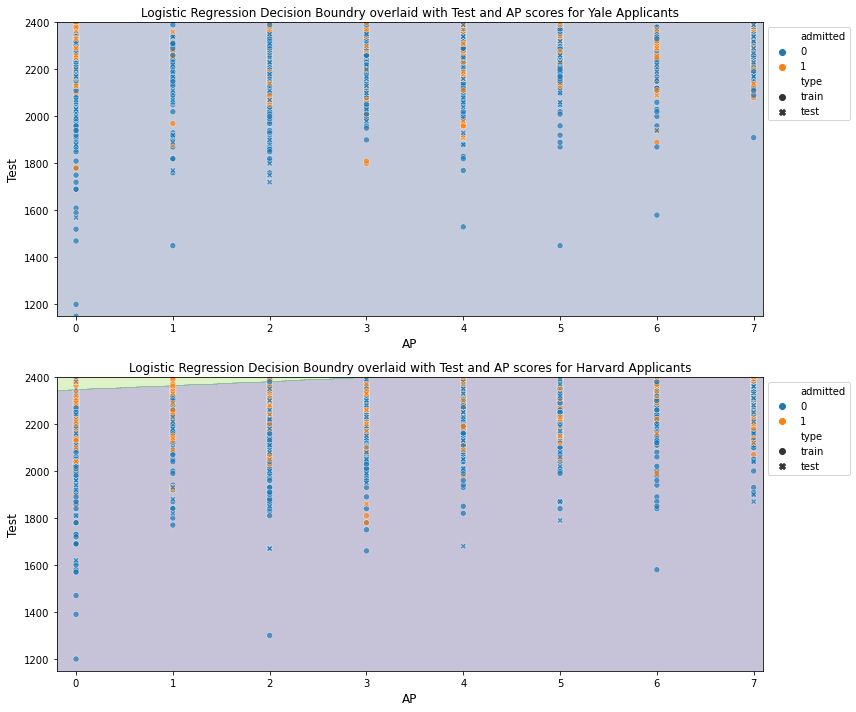

In [15]:
colors = ['yellow', 'blue']
applicants = ['Yale', 'Harvard']

X_train = college_train[["harvard", "test", "ap", "admitted"]]
X_test = college_test[["harvard", "test", "ap", "admitted"]] 
X_train['type'] = 'train'
X_test['type'] = 'test'
train_test = pd.concat([X_train,X_test])
Y_train_test = pd.concat([y_train,y_test])

f, ax = plt.subplots(2, 1, figsize=(12, 10))

for i in range(2):
    # train grid
    X_train_test = train_test[train_test['harvard']==i]
    y_train_test = Y_train_test[X_train_test.index]

    x_1 = X_train['ap']
    x_2 = X_train['test']
    x_1_min, x_1_max = x_1.min() - 0.2, x_1.max() + 0.2
    x_2_min, x_2_max = x_2.min() - 0.2, x_2.max() + 0.2
    xx_1, xx_2 = np.meshgrid(
        np.arange(x_1_min, x_1_max, 0.1),
        np.arange(x_2_min, x_2_max, 0.1),
    )
    ones = np.array([i] * xx_1.ravel().shape[0])
    X_mesh = np.stack((ones, xx_2.ravel(),xx_1.ravel(),xx_2.ravel()*i,xx_1.ravel()*i),axis=1)

    Z = logit3_2.predict(X_mesh)
    Z = Z.reshape(xx_1.shape)
    ax[i].contourf(xx_1, xx_2, Z, alpha=0.3, levels=2, color = colors)
    
    sns.scatterplot(
        data = X_train_test,
        x = 'ap',
        y = 'test',
        hue = "admitted",
        style = 'type',
        alpha = 0.7,
        ax = ax[i]
    )
    
    ax[i].legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    ax[i].set_title(f'Logistic Regression Decision Boundry overlaid with Test and AP scores for {applicants[i]} Applicants')
    ax[i].set_ylabel('Test', size = 12)
    ax[i].set_xlabel('AP', size = 12)
    plt.tight_layout()
    

**INTERPRETATION:**

**Comparing these two plots, there is an observable decision boundary for Harvard applicants but no observable decision boundary for Yale applicants.**

<div class='exercise-r'>

**3.6** Fit a logistic regression model (call it `logit3_6`) to predict `admitted` from 4 predictors: `["harvard", "test", "female", "minority"]` along with 2 interaction terms: `harvard` with `female` and `harvard` with `minority`.  Print out the coefficient estimates for this model.
    
</div>

In [16]:
# your code here
X_train = college_train[["harvard", "test", "female", "minority"]]
y_train = college_train['admitted']

X_train['harvard_female'] = X_train['harvard'] * X_train['female']
X_train['harvard_minority'] = X_train['harvard'] * X_train['minority']

logit3_6 = LogisticRegression(penalty="none")
logit3_6.fit(X_train,y_train)

print(f"Logistic Regression Estimated Beta (B0): {logit3_6.intercept_[0]:.4f}.")
for i in range(6):
    print(f"Logistic Regression Estimated Beta (B{i+1}): {logit3_6.coef_[0][i]:.4f}.")

Logistic Regression Estimated Beta (B0): -4.6996.
Logistic Regression Estimated Beta (B1): -0.0213.
Logistic Regression Estimated Beta (B2): 0.0017.
Logistic Regression Estimated Beta (B3): -0.8359.
Logistic Regression Estimated Beta (B4): 1.2202.
Logistic Regression Estimated Beta (B5): 1.0162.
Logistic Regression Estimated Beta (B6): -1.5148.


<ipython-input-16-011d9d02f8de>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['harvard_female'] = X_train['harvard'] * X_train['female']
<ipython-input-16-011d9d02f8de>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['harvard_minority'] = X_train['harvard'] * X_train['minority']
/Users/dizhen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the n

<div class='exercise-r'>

**3.7** Interpret the coefficients associated with `female` and `minority` (the two main effects AND the two interaction terms).
    
</div>

The full model can be written as

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 \text{harvard} + \beta_2 \text{test} + \beta_3 \text{female} + \beta_4 \text{minority} + \beta_5 \text{harvard} * \text{female} + \beta_6 \text{harvard} * \text{minority} $$

For those who is applying to Harvard

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 + \beta_2 \text{test} + (\beta_3 + \beta_5) \text{female} + (\beta_4 + \beta_6) \text{minority} $$

For those who is applying to Yale

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0  + \beta_2 \text{test} + \beta_3 \text{female} + \beta_4 \text{minority} $$


where $\beta_0 = -4.6996, \beta_1 = -0.0213, \beta_2 = 0.0017, \beta_3 = -0.8359, \beta_4 = 1.2202, \beta_5 = 1.0162, \beta_6 = -1.5148$.


Among those who is applying to Harvard, the odds of getting admitted among female is $\exp(\beta_3 + \beta_5)=1.1976$ times the odds of getting admitted among male. Among those who is applying to Yale, the odds of getting admitted among female is $\exp(\beta_3) =0.4335$ times the odds of getting admitted among male.

Among those who is applying to Harvard, the odds of getting admitted among under-represented minority is $\exp(\beta_4 + \beta_6) = 0.7448$ times the odds of getting admitted among non under-represented minority. Among those who is applying to Yale, the odds of getting admitted among under-represented minority is $\exp(\beta_4)=3.3879$ times the odds of getting admitted among non under-represented minority.



<div class='exercise-r'>

**3.8** Based on this sample, how does it appear that Harvard and Yale compare in admitting these groups?  Why would it be wrong to take this interpretation as truth?

</div>

**It seems that under-represented minority is more likely to be admitted by Yale. Female are more likely to be admitted to Harvard. This might be not true due to selection bias when collecting data.**

---

<a id="part4"></a>

## <div class='exercise'>Question 4: Building predictive models for admitted [24 pts]</div>

[Return to contents](#contents)

**4.1** You were instructed to NOT scale predictors in the prior sections above. The primary reason for this was to focus instead on the interpretability of our logistic regression coefficients. However, as we're sure you noticed, the numeric scale among our different predictors varies greatly (i.e. `test` values are in the 1,000's while others are much, much smaller). In practice, we might want to put our predictors all on a similar scale, particularly for regularized regression and/or distance-based algorithms such as $k$-NN classification. (1) Please explain why scaling under these circumstances might be important. Then, (2) actually apply standardized scaling to all of the **non-binary** predictors in our original set of 12 predictors (for both the training and test sets).

**IMPORTANT:** These scaled predictors should be used instead of the original unscaled versions of the predictors for the remainder of this problem set.

**4.2** Fit a well-tuned $k$-NN classification model with main effects of all 12 predictors in it (call it `knn_model`).  Use `ks = [1, 3, 5, 9, 15, 21, 51, 71, 101, 131, 171, 201]` and 10-fold cross-validation with classification accuracy as the scoring metric. Plot, on a single set of axes, your resulting cross-validation mean training and mean validation scores at each value $k$. Then, report your chosen $k$ and the classification accuracy on train and test for your final fitted model.

**4.3** Fit the full logistic regression model (without penalty) with main effects of all 12 predictors in it (call it `logit_full`). Print out the coefficient estimates and report the classification accuracy on train and test for this model.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.

**4.4** Fit a well-tuned Lasso-like logistic regression model from all 12 predictors in it (call it `logit_lasso`). Use `Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]` and 10-fold cross-validation with classification accuracy as the scoring metric.  Print out the coefficient estimates and report the classification accuracy on train and test for this model.

**4.5** Which predictors were deemed important in `logit_lasso`?  Which were deemed unimportant? Please remember that, as a general practice, zero-value Lasso coefficients (i.e. $\beta_i=0$) are considered "unimportant".

**4.6** Fit a well-tuned Lasso-like logistic regression model with all important predictors from `logit_lasso` and all the unique 2-way interactions between them (call it `logit_lasso_interact`).  Again use `Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]` and 10-fold cross-validation with classification accuracy as the scoring metric. Report the classification accuracy on train and test for this model.

**4.7** How many of the predictors in our `logit_lasso_interact` model were deemed important and unimportant? (Feel free to just report on the number of them found to be important and unimportant. There is no need to list them all here.)

<a id="part4solutions"></a>

## Question 4: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**4.1** You were instructed to NOT scale predictors in the prior sections above. The primary reason for this was to focus instead on the interpretability of our logistic regression coefficients. However, as we're sure you noticed, the numeric scale among our different predictors varies greatly (i.e. `test` values are in the 1,000's while others are much, much smaller). In practice, we might want to put our predictors all on a similar scale, particularly for regularized regression and/or distance-based algorithms such as $k$-NN classification. (1) Please explain why scaling under these circumstances might be important. Then, (2) actually apply standardized scaling to all of the **non-binary** predictors in our original set of 12 predictors (for both the training and test sets).

**IMPORTANT:** These scaled predictors should be used instead of the original unscaled versions of the predictors for the remainder of this problem set.

</div>

**INTERPRETATION:**

**It's necessary to scale the data predictors for regularized regression, because regularization behaves differently for different scaling. For example, L2 regularization pushes larger weights towards zero more strongly than smaller weights. It's necessary to scale the data predictors for distance-based algorithms such as kNN classification, because deciding not to scale the data will lead to drastically misleading predictions.**

In [17]:
# your code here
X_train = college_train[["test", "avg_ap", "gpa", "ap", "sat_subjects","female", "minority",
                         "international","sports", "harvard", "early_app", "alumni"]]
X_test = college_test[["test", "avg_ap", "gpa", "ap", "sat_subjects","female", "minority",
                       "international","sports", "harvard", "early_app", "alumni"]]

X_train_nonbi = pd.DataFrame(StandardScaler().fit_transform(X_train[["test", "avg_ap", "gpa", "ap", "sat_subjects"]]), 
                             columns= ["test", "avg_ap", "gpa", "ap", "sat_subjects"]).reset_index()
X_train_bi = X_train[["female", "minority","international","sports", "harvard", "early_app", "alumni"]].reset_index()

X_train = pd.concat([X_train_nonbi,X_train_bi], axis = 1)[["test", "avg_ap", "gpa", "ap", "sat_subjects","female", "minority",
                         "international","sports", "harvard", "early_app", "alumni"]]


X_test_nonbi = pd.DataFrame(StandardScaler().fit_transform(X_test[["test", "avg_ap", "gpa", "ap", "sat_subjects"]]), 
                             columns= ["test", "avg_ap", "gpa", "ap", "sat_subjects"]).reset_index()
X_test_bi = X_test[["female", "minority","international","sports", "harvard", "early_app", "alumni"]].reset_index()

X_test = pd.concat([X_test_nonbi,X_test_bi], axis = 1)[["test", "avg_ap", "gpa", "ap", "sat_subjects","female", "minority",
                         "international","sports", "harvard", "early_app", "alumni"]]




<div class='exercise-r'>

**4.2** Fit a well-tuned $k$-NN classification model with main effects of all 12 predictors in it (call it `knn_model`).  Use `ks = [1, 3, 5, 9, 15, 21, 51, 71, 101, 131, 171, 201]` and 10-fold cross-validation with classification accuracy as the scoring metric. Plot, on a single set of axes, your resulting cross-validation mean training and mean validation scores at each value $k$. Then, report your chosen $k$ and the classification accuracy on train and test for your final fitted model.
    
</div>

In [18]:
np.random.seed(121) # Do not delete or modify this line of code

# your code here
ks = [1, 3, 5, 9, 15, 21, 51, 71, 101, 131, 171, 201]
cv = 10
accs_tr = []
accs_ts = []
for k in ks:
    knn_model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    scores = cross_validate(knn_model, X_train, y_train, cv=cv, scoring="accuracy", return_train_score=True)
    accs_tr.append(scores['train_score'].mean())
    accs_ts.append(scores['test_score'].mean())
best_k = ks[accs_ts.index(max(accs_ts))]

knn_model = KNeighborsClassifier(n_neighbors=best_k).fit(X_train, y_train)
y_train_pred = knn_model.predict(X_train)
y_test_pred = knn_model.predict(X_test)
y_test_proba_knn_model = knn_model.predict_proba(X_test)
train_acc_knn_model = accuracy_score(y_train, y_train_pred)*100
test_acc_knn_model = accuracy_score(y_test, y_test_pred)*100
print(f"The best k (resulting in highest accuracy on testing data) is {best_k}.")
   
print(f"The accuracy of logistic regression on training data is {train_acc_knn_model:.2f}%.")
print(f"The accuracy of logistic regression on test data is {test_acc_knn_model:.2f}%.")

The best k (resulting in highest accuracy on testing data) is 21.
The accuracy of logistic regression on training data is 74.40%.
The accuracy of logistic regression on test data is 71.20%.


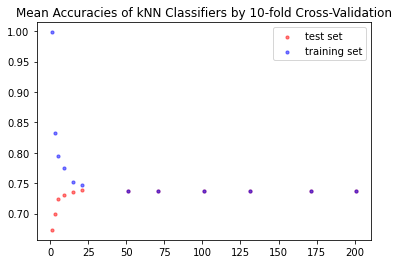

In [19]:
accs_ts.index(min(accs_ts))
fig, ax = plt.subplots()
plt.scatter(ks,accs_ts,color='red', label = 'test set', s=10, alpha= 0.5)
plt.scatter(ks,accs_tr,color='blue', label = 'training set', s=10, alpha= 0.5)
plt.title("Mean Accuracies of kNN Classifiers by 10-fold Cross-Validation")
ax.legend()

<div class='exercise-r'>

**4.3** Fit the full logistic regression model (without penalty) with main effects of all 12 predictors in it (call it `logit_full`). Print out the coefficient estimates and report the classification accuracy on train and test for this model.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.
    
</div>

In [20]:
# your code here
X_train = college_train[["test", "avg_ap", "gpa", "ap", "sat_subjects","female", "minority",
                         "international","sports", "harvard", "early_app", "alumni"]]
X_test = college_test[["test", "avg_ap", "gpa", "ap", "sat_subjects","female", "minority",
                       "international","sports", "harvard", "early_app", "alumni"]]

X_train_nonbi = pd.DataFrame(StandardScaler().fit_transform(X_train[["test", "avg_ap", "gpa", "ap", "sat_subjects"]]), 
                             columns= ["test", "avg_ap", "gpa", "ap", "sat_subjects"]).reset_index()
X_train_bi = X_train[["female", "minority","international","sports", "harvard", "early_app", "alumni"]].reset_index()

X_train = pd.concat([X_train_nonbi,X_train_bi], axis = 1)[["test", "avg_ap", "gpa", "ap", "sat_subjects","female", "minority",
                         "international","sports", "harvard", "early_app", "alumni"]]


X_test_nonbi = pd.DataFrame(StandardScaler().fit_transform(X_test[["test", "avg_ap", "gpa", "ap", "sat_subjects"]]), 
                             columns= ["test", "avg_ap", "gpa", "ap", "sat_subjects"]).reset_index()
X_test_bi = X_test[["female", "minority","international","sports", "harvard", "early_app", "alumni"]].reset_index()

X_test = pd.concat([X_test_nonbi,X_test_bi], axis = 1)[["test", "avg_ap", "gpa", "ap", "sat_subjects","female", "minority",
                         "international","sports", "harvard", "early_app", "alumni"]]


logit_full = LogisticRegression(penalty="none")
logit_full.fit(X_train,y_train)

y_train_pred = logit_full.predict(X_train)
y_test_pred = logit_full.predict(X_test)
y_test_proba_logit_full = logit_full.predict_proba(X_test)
train_acc_logit_full = accuracy_score(y_train,y_train_pred)*100
test_acc_logit_full = accuracy_score(y_test,y_test_pred)*100

print(f"Logistic Regression Estimated Beta (B0): {logit_full.intercept_[0]:.4f}.")
for i in range(12):
    print(f"Logistic Regression Estimated Beta (B{i+1}): {logit_full.coef_[0][i]:.4f}.")
    
print(f"The accuracy of logistic regression on training data is {train_acc_logit_full:.2f}%.")
print(f"The accuracy of logistic regression on test data is {test_acc_logit_full:.2f}%.")

Logistic Regression Estimated Beta (B0): -1.7090.
Logistic Regression Estimated Beta (B1): 0.7838.
Logistic Regression Estimated Beta (B2): 0.0975.
Logistic Regression Estimated Beta (B3): 0.1056.
Logistic Regression Estimated Beta (B4): -0.1403.
Logistic Regression Estimated Beta (B5): -0.0952.
Logistic Regression Estimated Beta (B6): 0.0518.
Logistic Regression Estimated Beta (B7): 0.9165.
Logistic Regression Estimated Beta (B8): 0.4500.
Logistic Regression Estimated Beta (B9): 1.2334.
Logistic Regression Estimated Beta (B10): 0.2581.
Logistic Regression Estimated Beta (B11): 0.3737.
Logistic Regression Estimated Beta (B12): 0.6629.
The accuracy of logistic regression on training data is 74.53%.
The accuracy of logistic regression on test data is 70.93%.


<div class='exercise-r'>

**4.4** Fit a well-tuned Lasso-like logistic regression model from all 12 predictors in it (call it `logit_lasso`). Use `Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]` and 10-fold cross-validation with classification accuracy as the scoring metric.  Print out the coefficient estimates and report the classification accuracy on train and test for this model.

</div>

In [21]:
# your code here
X_train = college_train[["test", "avg_ap", "gpa", "ap", "sat_subjects","female", "minority",
                         "international","sports", "harvard", "early_app", "alumni"]]
X_test = college_test[["test", "avg_ap", "gpa", "ap", "sat_subjects","female", "minority",
                       "international","sports", "harvard", "early_app", "alumni"]]

X_train_nonbi = pd.DataFrame(StandardScaler().fit_transform(X_train[["test", "avg_ap", "gpa", "ap", "sat_subjects"]]), 
                             columns= ["test", "avg_ap", "gpa", "ap", "sat_subjects"]).reset_index()
X_train_bi = X_train[["female", "minority","international","sports", "harvard", "early_app", "alumni"]].reset_index()

X_train = pd.concat([X_train_nonbi,X_train_bi], axis = 1)[["test", "avg_ap", "gpa", "ap", "sat_subjects","female", "minority",
                         "international","sports", "harvard", "early_app", "alumni"]]


X_test_nonbi = pd.DataFrame(StandardScaler().fit_transform(X_test[["test", "avg_ap", "gpa", "ap", "sat_subjects"]]), 
                             columns= ["test", "avg_ap", "gpa", "ap", "sat_subjects"]).reset_index()
X_test_bi = X_test[["female", "minority","international","sports", "harvard", "early_app", "alumni"]].reset_index()

X_test = pd.concat([X_test_nonbi,X_test_bi], axis = 1)[["test", "avg_ap", "gpa", "ap", "sat_subjects","female", "minority",
                         "international","sports", "harvard", "early_app", "alumni"]]


Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
cv = 10
accs_tr = []
accs_ts = []
for c in Cs:
    logit_lasso = LogisticRegression(penalty='l1', solver = "liblinear", C = c).fit(X_train, y_train)
    scores = cross_validate(logit_lasso, X_train, y_train, cv=cv, scoring="accuracy", return_train_score=True)
    accs_tr.append(scores['train_score'].mean())
    accs_ts.append(scores['test_score'].mean())
best_c = Cs[accs_ts.index(max(accs_ts))]
print(f"The best c (resulting in highest accuracy on testing data) is {best_c}.")

# final 
logit_lasso = LogisticRegression(penalty='l1', solver = "liblinear", C = best_c).fit(X_train, y_train)
y_train_pred = logit_lasso.predict(X_train)
y_test_pred = logit_lasso.predict(X_test)
y_test_proba_logit_lasso = logit_lasso.predict_proba(X_test)
train_acc_logit_lasso = accuracy_score(y_train, y_train_pred)*100
test_acc_logit_lasso = accuracy_score(y_test, y_test_pred)*100

print(f"The accuracy of logistic regression on training data is {train_acc_logit_lasso:.2f}%.")
print(f"The accuracy of logistic regression on test data is {test_acc_logit_lasso:.2f}%.")
print(f"The coefficients are: {logit_lasso.coef_[0]}.")

The best c (resulting in highest accuracy on testing data) is 10.0.
The accuracy of logistic regression on training data is 74.53%.
The accuracy of logistic regression on test data is 70.67%.
The coefficients are: [ 0.78191843  0.09518917  0.10454028 -0.13875588 -0.09432887  0.04923301
  0.91204104  0.44033259  1.22137061  0.25438176  0.37010988  0.65623782].


<div class='exercise-r'>

**4.5** Which predictors were deemed important in `logit_lasso`?  Which were deemed unimportant? Please remember that, as a general practice, zero-value Lasso coefficients (i.e. $\beta_i=0$) are considered "unimportant".
 
</div>

In [22]:
# your code here
print(f"The coefficients are: {logit_lasso.coef_[0]}.")
print(f"Since all Lasso coefficients are not zero, they are all considered important.")

The coefficients are: [ 0.78191843  0.09518917  0.10454028 -0.13875588 -0.09432887  0.04923301
  0.91204104  0.44033259  1.22137061  0.25438176  0.37010988  0.65623782].
Since all Lasso coefficients are not zero, they are all considered important.


<div class='exercise-r'>

**4.6** Fit a well-tuned Lasso-like logistic regression model with all important predictors from `logit_lasso` and all the unique 2-way interactions between them (call it `logit_lasso_interact`).  Again use `Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]` and 10-fold cross-validation with classification accuracy as the scoring metric. Report the classification accuracy on train and test for this model.

</div>

In [23]:
# your code here
X_train = college_train[["test", "avg_ap", "gpa", "ap", "sat_subjects","female", "minority",
                         "international","sports", "harvard", "early_app", "alumni"]]
X_test = college_test[["test", "avg_ap", "gpa", "ap", "sat_subjects","female", "minority",
                       "international","sports", "harvard", "early_app", "alumni"]]

X_train_nonbi = pd.DataFrame(StandardScaler().fit_transform(X_train[["test", "avg_ap", "gpa", "ap", "sat_subjects"]]), 
                             columns= ["test", "avg_ap", "gpa", "ap", "sat_subjects"]).reset_index()
X_train_bi = X_train[["female", "minority","international","sports", "harvard", "early_app", "alumni"]].reset_index()

X_train = pd.concat([X_train_nonbi,X_train_bi], axis = 1)[["test", "avg_ap", "gpa", "ap", "sat_subjects","female", "minority",
                         "international","sports", "harvard", "early_app", "alumni"]]


X_test_nonbi = pd.DataFrame(StandardScaler().fit_transform(X_test[["test", "avg_ap", "gpa", "ap", "sat_subjects"]]), 
                             columns= ["test", "avg_ap", "gpa", "ap", "sat_subjects"]).reset_index()
X_test_bi = X_test[["female", "minority","international","sports", "harvard", "early_app", "alumni"]].reset_index()

X_test = pd.concat([X_test_nonbi,X_test_bi], axis = 1)[["test", "avg_ap", "gpa", "ap", "sat_subjects","female", "minority",
                         "international","sports", "harvard", "early_app", "alumni"]]

interactions = PolynomialFeatures(interaction_only=True,include_bias = False)

X_train_inter = interactions.fit_transform(X_train)
X_test_inter = interactions.transform(X_test)
        
# logit lasso
Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
cv = 10
accs_tr = []
accs_ts = []
for c in Cs:
    logit_lasso_interact = LogisticRegression(penalty='l1', solver = "liblinear", C = c).fit(X_train_inter, y_train)
    scores = cross_validate(logit_lasso_interact, X_train_inter, y_train, cv=cv, scoring="accuracy", return_train_score=True)
    accs_tr.append(scores['train_score'].mean())
    accs_ts.append(scores['test_score'].mean())
best_c = Cs[accs_ts.index(max(accs_ts))]
print(f"The best c (resulting in highest accuracy on testing data) is {best_c}.")

# final
logit_lasso_interact = LogisticRegression(penalty='l1', solver = "liblinear", C = best_c).fit(X_train_inter, y_train)
y_train_pred = logit_lasso_interact.predict(X_train_inter)
y_test_pred = logit_lasso_interact.predict(X_test_inter)
y_test_proba_logit_lasso_interact = logit_lasso_interact.predict_proba(X_test_inter)
train_acc_logit_lasso_interact = accuracy_score(y_train, y_train_pred)*100
test_acc_logit_lasso_interact = accuracy_score(y_test, y_test_pred)*100

print(f"The accuracy of logistic regression on training data is {train_acc_logit_lasso_interact:.2f}%.")
print(f"The accuracy of logistic regression on test data is {test_acc_logit_lasso_interact:.2f}%.")
print(f"The coefficients are: {logit_lasso_interact.coef_[0]}.")

The best c (resulting in highest accuracy on testing data) is 1.0.
The accuracy of logistic regression on training data is 76.47%.
The accuracy of logistic regression on test data is 70.67%.
The coefficients are: [ 0.56995861 -0.10431822  0.13602436  0.0703481  -0.00942526 -0.12080413
  1.33326613  0.          1.45525756  0.07801242  0.3842038   0.02661948
  0.00491917  0.12946745 -0.04900709 -0.06363385  0.08053999  0.09687589
  0.17453122  0.          0.23551252 -0.36745541  1.0987086  -0.18514202
  0.          0.13699988  0.05477081  0.2440511   0.16519229 -0.10074692
  0.29883589  0.20943399  0.15934263  0.06551766  0.         -0.00423388
  0.21979475  0.         -0.40007218  0.         -0.02008863  0.
 -0.06061714  0.0463466   0.         -0.54338517 -0.18525479 -0.32429987
 -0.19006856  0.05343817  0.00561478  0.          1.12793494  0.
 -0.24179736  0.01072416  0.02469472 -0.27810828  0.16344896 -0.70969232
  0.34130537  0.24737727  0.         -0.13952656 -0.42370711 -0.42092698


In [24]:
# encode interactions
cols = ["test", "avg_ap", "gpa", "ap", "sat_subjects","female", "minority",
                     "international","sports", "harvard", "early_app", "alumni"]
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        var_name = cols[i] + '_' + cols[j]
        X_train[var_name] = X_train[cols[i]] * X_train[cols[j]]
        X_test[var_name] = X_test[cols[i]] * X_test[cols[j]]

<div class='exercise-r'>

**4.7** How many of the predictors in our `logit_lasso_interact` model were deemed important and unimportant? (Feel free to just report on the number of them found to be important and unimportant. There is no need to list them all here.)
    
</div>

In [25]:
# your code here
print(f"The coefficients are: {logit_lasso_interact.coef_[0]}.")
print(f"{sum(1*(logit_lasso_interact.coef_[0] == 0))} predictors with 0 coefficients are considered unimportant. {sum(1*(logit_lasso_interact.coef_[0] != 0))} predictors with non zero coefficients are considered important.")

The coefficients are: [ 0.56995861 -0.10431822  0.13602436  0.0703481  -0.00942526 -0.12080413
  1.33326613  0.          1.45525756  0.07801242  0.3842038   0.02661948
  0.00491917  0.12946745 -0.04900709 -0.06363385  0.08053999  0.09687589
  0.17453122  0.          0.23551252 -0.36745541  1.0987086  -0.18514202
  0.          0.13699988  0.05477081  0.2440511   0.16519229 -0.10074692
  0.29883589  0.20943399  0.15934263  0.06551766  0.         -0.00423388
  0.21979475  0.         -0.40007218  0.         -0.02008863  0.
 -0.06061714  0.0463466   0.         -0.54338517 -0.18525479 -0.32429987
 -0.19006856  0.05343817  0.00561478  0.          1.12793494  0.
 -0.24179736  0.01072416  0.02469472 -0.27810828  0.16344896 -0.70969232
  0.34130537  0.24737727  0.         -0.13952656 -0.42370711 -0.42092698
  0.          0.328511    0.          0.         -0.0949609   0.
  0.          0.43827297  0.         -0.2005683   0.53019099  0.        ].
18 predictors with 0 coefficients are considered un

---

<a id="part5"></a>

## <div class='exercise'>Question 5: Evaluating results [12 pts]</div>

[Return to contents](#contents)

**5.1** Which of the 4 models in Question 4 performs the best based on classification accuracy?  Which performs the worst? Based on these accuracies, how do these models perform compared to your baseline "naive" model back in Question 1.1? What does this comparison to the "naive" model tell us?

**5.2** Draw the four ROC curves on the same set of axes using the test data.  How do these ROC curves compare?  Do the ROC curves support that the best model identified in Question 5.1 is better than the worst model identified in 5.1?  How do you know?

**5.3** Calculate and report AUC for all 4 models.  Do the rankings of these 4 models based on AUC match those for classification accuracy?  Why do you think this is the case?

**5.4** If you were to use one of these 4 models to present as a prediction model for the website [collegedata.com](https://www.collegedata.com/), which would you use and why?  What may be the biggest issue if this was a publicly available tool for college applicants to use to determine their chances of getting into Harvard and/or Yale?


<a id="part5solutions"></a>

## Question 5: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**5.1** Which of the 4 models in Question 4 performs the best based on classification accuracy?  Which performs the worst? Based on these accuracies, how do these models perform compared to your baseline "naive" model back in Question 1.1? What does this comparison to the "naive" model tell us?
    
</div>

In [26]:
# your code here
print(f"The knn_model model with best k of {best_k} in Q4 performs the best based on classification accuracy on test data ({test_acc_knn_model:.2f}%).")
print(f"The logit_lasso and logit_lasso_interact models in Q4 perform the worst based on classification accuracy on test data ({test_acc_logit_lasso:.2f}% and {test_acc_logit_lasso_interact:.2f}%).")


The knn_model model with best k of 21 in Q4 performs the best based on classification accuracy on test data (71.20%).
The logit_lasso and logit_lasso_interact models in Q4 perform the worst based on classification accuracy on test data (70.67% and 70.67%).


**INTERPRETATION:**

**The knn_model model with best k of 21 in Q4 performs the best based on classification accuracy on test data (71.20%). The logit_lasso and logit_lasso_interact models in Q4 perform the worst based on classification accuracy on test data (70.67% and 70.67%). Compared to the baseline naive model in Q1.1, the models in Q4 perform better.**

<div class='exercise-r'>

**5.2** Draw the four ROC curves on the same set of axes using the test data.  How do these ROC curves compare?  Do the ROC curves support that the best model identified in Question 5.1 is better than the worst model identified in 5.1?  How do you know?
    
</div>

Text(0, 0.5, 'TPR')

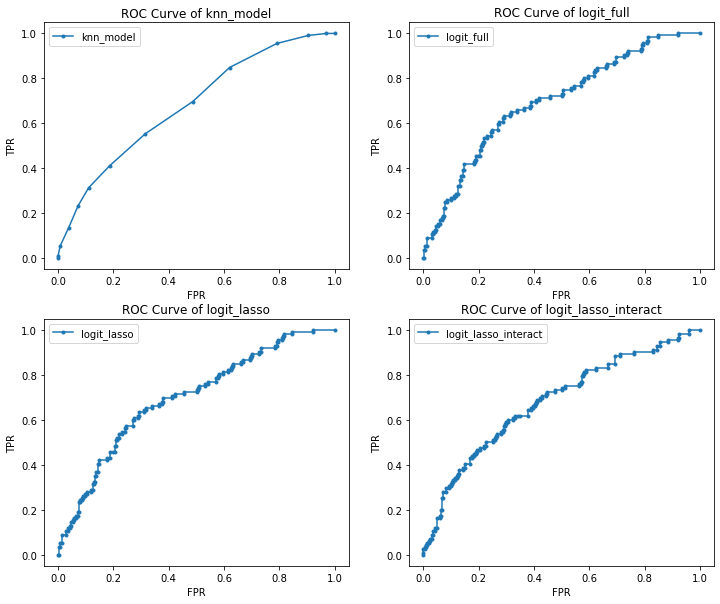

In [27]:
# your code here
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_test_proba_knn_model[:,1])
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_test_proba_logit_full[:,1])
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_test_proba_logit_lasso[:,1])
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_test_proba_logit_lasso_interact[:,1])

f, ax = plt.subplots(2, 2, figsize=(12, 10))
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_test_proba_knn_model[:,1])
ax[0,0].plot(lr_fpr, lr_tpr, marker='.', label='knn_model')
ax[0,0].legend()
ax[0,0].set_title("ROC Curve of knn_model")
ax[0,0].set_xlabel('FPR')
ax[0,0].set_ylabel('TPR')

lr_fpr, lr_tpr, _ = roc_curve(y_test, y_test_proba_logit_full[:,1])
ax[0,1].plot(lr_fpr, lr_tpr, marker='.', label='logit_full')
ax[0,1].legend()
ax[0,1].set_title("ROC Curve of logit_full")
ax[0,1].set_xlabel('FPR')
ax[0,1].set_ylabel('TPR')

lr_fpr, lr_tpr, _ = roc_curve(y_test, y_test_proba_logit_lasso[:,1])
ax[1,0].plot(lr_fpr, lr_tpr, marker='.', label='logit_lasso')
ax[1,0].legend()
ax[1,0].set_title("ROC Curve of logit_lasso")
ax[1,0].set_xlabel('FPR')
ax[1,0].set_ylabel('TPR')

lr_fpr, lr_tpr, _ = roc_curve(y_test, y_test_proba_logit_lasso_interact[:,1])
ax[1,1].plot(lr_fpr, lr_tpr, marker='.', label='logit_lasso_interact')
ax[1,1].legend()
ax[1,1].set_title("ROC Curve of logit_lasso_interact")
ax[1,1].set_xlabel('FPR')
ax[1,1].set_ylabel('TPR')


**INTERPRETATION:**

**When we comparing these ROC curves, we want our best model's ROC curve to be far from the straight line y=x. By observing these four plots, I don't think I can differentiate which is better and which is worse. But these models are better than random guess because the area under the curve (AUC) is higher than 0.5.**

<div class='exercise-r'>

**5.3** Calculate and report AUC for all 4 models.  Do the rankings of these 4 models based on AUC match those for classification accuracy?  Why do you think this is the case?
    
</div>

In [28]:
# your code here
knn_model_auc = roc_auc_score(y_test, y_test_proba_knn_model[:,1])
logit_full_auc = roc_auc_score(y_test, y_test_proba_logit_full[:,1])
logit_lasso_auc = roc_auc_score(y_test, y_test_proba_logit_lasso[:,1])
logit_lasso_interact_auc = roc_auc_score(y_test, y_test_proba_logit_lasso_interact[:,1])
print(f"The AUC for knn_model model is {knn_model_auc:.4f}.")
print(f"The AUC for logit_full model is {logit_full_auc:.4f}.")
print(f"The AUC for logit_lasso model is {logit_lasso_auc:.4f}.")
print(f"The AUC for logit_lasso_interact model is {logit_lasso_interact_auc:.4f}.")

The AUC for knn_model model is 0.6793.
The AUC for logit_full model is 0.6970.
The AUC for logit_lasso model is 0.6970.
The AUC for logit_lasso_interact model is 0.6796.


**INTERPRETATION:**

**logit_full model and logit_lasso model achieve the highest AUC values. This is not consistent with classification accuracy. I think this is because AUC and accuracy are difference measurement focusing on measuring model perform from different perspective. For example, accuracy measures the proportion of accurate predictions among all prodictions, while AUC is calculated based on FPR and TPR.**

<div class='exercise-r'>

**5.4** If you were to use one of these 4 models to present as a prediction model for the website [collegedata.com](https://www.collegedata.com/), which would you use and why?  What may be the biggest issue if this was a publicly available tool for college applicants to use to determine their chances of getting into Harvard and/or Yale?
    
</div>

**I will use logit_full and I choose this model based on both accuracy and AUC. The accuracy of logit_full is mediate compared to other models. The AUC of logit_full is the highest. I think the biggest issue is that the data we used to build models are collected from volunteers so this procedure may introduce bias and make our model misleading. Therefore, it could give college applicants misleading information and they could make wrong decisions.**

#### THE END

[Return to contents](#contents)